# Blue micro-LEDs with inclined sidewalls

LEDs have become essential light sources, with applications ranging far beyond simple illumination, including optical communication and, notably, display technologies. Among these, µ-LEDs based on InGaN have emerged as promising platforms for next-generation displays, particularly in applications such as augmented reality.

As LEDs are miniaturized for these advanced uses, maintaining high internal quantum efficiency (IQE) and light extraction efficiency (LEE) becomes increasingly challenging. Precise control over fabrication parameters, such as the sidewall angle, becomes critical for achieving high LEE and desirable far-field emission profiles. In this context, electromagnetic (EM) simulations play a crucial role, allowing for the exploration of design variations and identification of optimal parameters before committing to costly fabrication processes.

However, accurately simulating LED sources presents unique challenges. LED emission is inherently incoherent, while EM simulations typically use coherent sources, which can introduce unrealistic interference effects. A common technique to approximate incoherent emission involves averaging the intensity profiles generated by multiple dipole sources distributed across the emitting region. While this method effectively captures the statistical nature of incoherent light, it requires a large number of simulations to reduce variance in the results.

For symmetric structures, the computational cost can be significantly reduced. In this particular model, circular symmetry is exploited by placing dipole sources at various radial positions and averaging over the azimuthal (ϕ) angle. This approach enables efficient simulation of incoherent emission while preserving the accuracy of spatially averaged field distributions. 

This notebook demonstrates how to model a blue LED with inclined sidewalls using Tidy3D FDTD. The design is based on a recent study `Florian Vögl, Adrian Avramescu, Andreas Lex, Andreas Waag, Martin Hetzl, and Norwin von Malm, "Enhanced forward emission by backside mirror design in micron-sized LEDs," Opt. Lett. 49, 5095-5098 (2024)`.

<img src="img/microLED.png" width="500" alt="Schematic of the micro LED">

In [1]:
# library imports
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web

## Simulation Setup

In [2]:
# define frequency and wavelength range

nm = 1e-3
lda0 = 450 * nm
freq0 = td.C_0 / lda0

Define the materials used in the simulation.

In [3]:
nGaN = td.Medium.from_nk(
    n=2.45, k=0, freq=freq0, viz_spec=td.VisualizationSpec(facecolor="lightsteelblue")
)
Al2O3 = td.Medium.from_nk(
    n=1.76, k=0, freq=freq0, viz_spec=td.VisualizationSpec(facecolor="darkorange")
)
SiO2 = td.Medium.from_nk(
    n=1.46, k=0, freq=freq0, viz_spec=td.VisualizationSpec(facecolor="goldenrod")
)
MQW = td.Medium.from_nk(
    n=2.60, k=0, freq=freq0, viz_spec=td.VisualizationSpec(facecolor="steelblue")
)
pGaN = td.Medium.from_nk(
    n=2.46, k=0, freq=freq0, viz_spec=td.VisualizationSpec(facecolor="cadetblue")
)
ITO = td.Medium.from_nk(
    n=2.00, k=0, freq=freq0, viz_spec=td.VisualizationSpec(facecolor="gainsboro")
)
metal = td.medium_from_nk(
    n=0.028, k=2.88, freq=freq0, viz_spec=td.VisualizationSpec(facecolor="gray")
)

Define geometric parameters, i.e. thickness of each layer.

In [4]:
t_nGaN = 1000 * nm
t_MQW = 50 * nm
t_pGaN = 150 * nm
t_ITO = 50 * nm
t_mirror = 120 * nm
t_Al2O3 = 40 * nm
t_SiO2 = 100 * nm
radius = 500 * nm

Define the structures in the simulation. 

In [5]:
t_1 = 500 * nm
infinity = 1e3
layer_nGaN = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-infinity, -infinity, 0), rmax=(infinity, infinity, t_nGaN))
    + td.Cylinder(center=(0, 0, -t_1 / 2), radius=radius, length=t_1),
    medium=nGaN,
    name="nGaN",
)

layer_MQW = td.Structure(
    geometry=td.Cylinder(center=(0, 0, -t_1 - t_MQW / 2), radius=radius, length=t_MQW),
    medium=MQW,
    name="MQW",
)

layer_pGaN = td.Structure(
    geometry=td.Cylinder(center=(0, 0, -t_1 - t_MQW - t_pGaN / 2), radius=radius, length=t_pGaN),
    medium=pGaN,
    name="pGaN",
)

layer_ITO = td.Structure(
    geometry=td.Cylinder(
        center=(0, 0, -t_1 - t_MQW - t_pGaN - t_ITO / 2), radius=radius, length=t_ITO
    ),
    medium=ITO,
    name="ITO",
)

layer_Al2O3 = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-infinity, -infinity, -t_Al2O3), rmax=(infinity, infinity, 0))
    + td.Cylinder(
        center=(0, 0, (-t_1 - t_MQW - t_pGaN - t_ITO - t_Al2O3) / 2),
        radius=radius + t_Al2O3,
        length=t_1 + t_MQW + t_pGaN + t_ITO + t_Al2O3,
    ),
    medium=Al2O3,
    name="Al2O3",
)

sidewall_angle = np.deg2rad(45)
radius_1 = 1.2
layer_SiO2 = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-infinity, -infinity, -t_Al2O3 - t_SiO2),
        rmax=(infinity, infinity, -t_Al2O3),
    )
    + td.Cylinder(
        center=(0, 0, -t_SiO2 + (-t_1 - t_MQW - t_pGaN - t_ITO - t_Al2O3) / 2),
        radius=radius_1,
        length=t_1 + t_MQW + t_pGaN + t_ITO + t_Al2O3,
        sidewall_angle=-sidewall_angle,
    ),
    medium=SiO2,
    name="SiO2",
)

radius_2 = 0.2
t_2 = 1.5
layer_silver = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(
            -infinity,
            -infinity,
            -t_1 - t_MQW - t_pGaN - t_ITO - t_Al2O3 - t_SiO2 - t_2,
        ),
        rmax=(infinity, infinity, -t_Al2O3 - t_SiO2),
    ),
    medium=metal,
    name="layer_silver",
)

contact = td.Structure(
    geometry=td.Cylinder(
        center=(0, 0, -t_1 - t_MQW - t_pGaN - t_ITO - (t_SiO2 + t_Al2O3) / 2),
        radius=radius_2,
        length=t_SiO2 + t_Al2O3,
    ),
    medium=metal,
    name="contact",
)

Define monitors used in the simulation.

In [6]:
theta_array = np.linspace(0, np.deg2rad(90), 180)  # polar angle
phi_array = np.linspace(0, 2 * np.pi, 360)  # azimuthal angle

projection_monitor = td.FieldProjectionAngleMonitor(
    center=(0, 0, lda0 / 8),
    size=(td.inf, td.inf, 0),
    freqs=[freq0],
    phi=phi_array,
    theta=theta_array,
    normal_dir="+",
    far_field_approx=True,
    name="far_field",
)

field_monitor = td.FieldMonitor(
    size=(td.inf, 0, td.inf), freqs=[freq0], fields=["Ex", "Ey", "Ez"], name="field"
)

Define a function to set up the simulation based on the dipole position and polarization. This function will be used later to create the necessary simulations for summing intensities and modeling the incoherent LED emission.

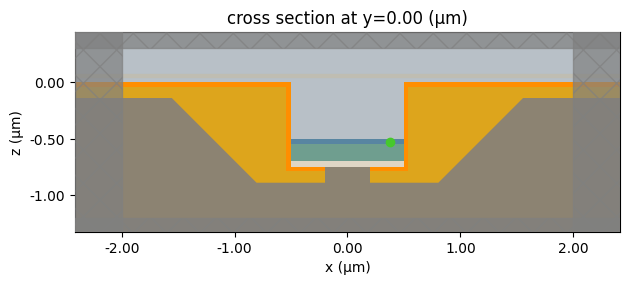

In [7]:
sim_box = td.Box.from_bounds(rmin=(-2, -2, -1.2), rmax=(2, 2, 0.3))


def make_sim(dipole_x, pol):
    dipole = td.PointDipole(
        center=(dipole_x, 0, -t_1 - t_MQW / 2),
        source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10),
        polarization=pol,
    )

    if pol == "Ex":
        symmetry = (0, 1, 0)
    elif pol == "Ey":
        symmetry = (0, -1, 0)
    else:
        symmetry = (0, 0, 0)

    sim = td.Simulation(
        center=sim_box.center,
        size=sim_box.size,
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=15),
        run_time=4e-12,
        structures=[
            layer_silver,
            layer_SiO2,
            layer_Al2O3,
            layer_nGaN,
            layer_MQW,
            layer_pGaN,
            layer_ITO,
            contact,
        ],
        sources=[dipole],
        monitors=[projection_monitor, field_monitor],
        boundary_spec=td.BoundarySpec(
            x=td.Boundary.absorber(),
            y=td.Boundary.absorber(),
            z=td.Boundary.pml(),
        ),
        symmetry=symmetry,
        shutoff=5e-5,
    )

    return sim


sim = make_sim(3 * radius / 4, "Ey")
sim.plot(y=0, monitor_alpha=0.1)
plt.show()

Visualizing grid.

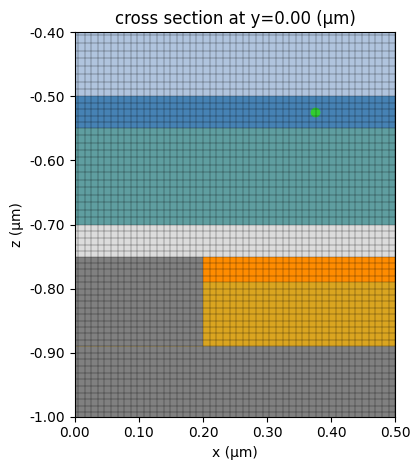

In [8]:
ax = sim.plot(y=0, monitor_alpha=0)
sim.plot_grid(y=0, ax=ax)
ax.set_xlim(0, 0.5)
ax.set_ylim(-1, -0.4)
plt.show()

In [9]:
print(f"Number of grid points: {sim.num_computational_grid_points / 1e6:.2f} M.")

Number of grid points: 17.60 M.


## Run a Single Simulation 

First we will carry out a test with a single simulation. The average runtime is about 2 minutes.

In [10]:
sim_data = web.run(sim, "microLED")

19:24:15 CEST Created task 'microLED' with task_id                              
              'fdve-c29098f4-0c92-4dca-adf6-acd9b5c6fe13' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=815862;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c29098f4-0c92-4dca-adf6-acd9b5c6fe13\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=497219;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c29098f4-0c92-4dca-adf6-acd9b5c6fe13\taskId]8;;\]8;id=815862;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c29098f4-0c92-4dca-adf6-acd9b5c6fe13\=]8;;\]8;id=92923;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c29098f4-0c92-4dca-adf6-acd9b5c6fe13\fdve]8;;\]8;id=815862;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c29098f4-0c92-4dca-adf6-acd9b5c6fe13\-c29098f4-0c]8;;\
              ]8;id=815862;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c29098f4-0c92-4dca-adf6-acd9b5c6fe13\92-4dca-adf6-acd9b5c6fe13']8;;\.

              Task folder: ]8;id=209368;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

19:24:17 CEST Maximum FlexCredit cost: 1.755. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

19:24:18 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

19:24:31 CEST status = preprocess

19:24:36 CEST starting up solver

              running solver

Output()

19:25:44 CEST early shutoff detected at 36%, exiting.

              status = success

              View simulation result at                                         
              ]8;id=417827;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c29098f4-0c92-4dca-adf6-acd9b5c6fe13\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=729288;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c29098f4-0c92-4dca-adf6-acd9b5c6fe13\taskId]8;;\]8;id=417827;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c29098f4-0c92-4dca-adf6-acd9b5c6fe13\=]8;;\]8;id=593380;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c29098f4-0c92-4dca-adf6-acd9b5c6fe13\fdve]8;;\]8;id=417827;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c29098f4-0c92-4dca-adf6-acd9b5c6fe13\-c29098f4-0c]8;;\
              ]8;id=417827;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c29098f4-0c92-4dca-adf6-acd9b5c6fe13\92-4dca-adf6-acd9b5c6fe13']8;;\.

Output()

19:25:47 CEST loading simulation from simulation_data.hdf5

Visualizing the fields.

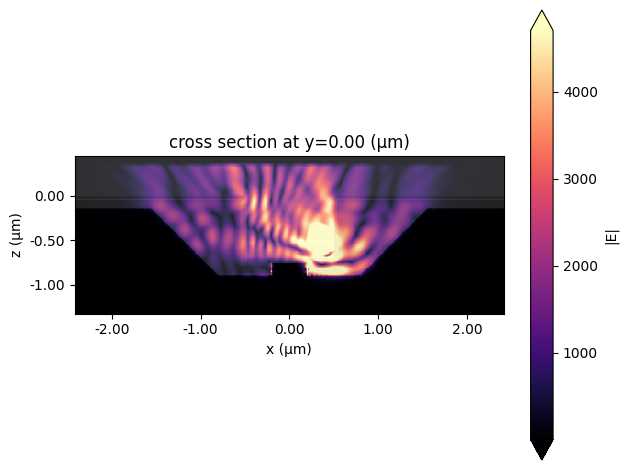

In [11]:
sim_data.plot_field("field", "E", "abs")
plt.show()

Far-field projection for a single source.

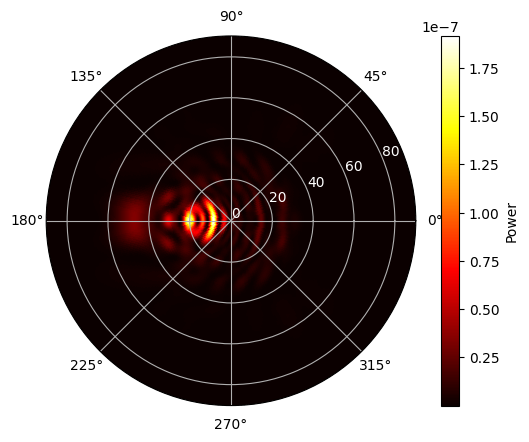

In [12]:
P = sim_data["far_field"].power.squeeze(drop=True)  # extract upward radiated power

# plot the radiation pattern in polar coordinates
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
plt.grid(False)
c = ax.pcolor(phi_array, np.rad2deg(theta_array), P, shading="auto", cmap="hot")
cb = fig.colorbar(c, ax=ax)
cb.set_label("Power")
_ = plt.setp(ax.get_yticklabels(), color="white")
ax.grid(True)

plt.show()

## Parameter Sweep

As we can see, a single source is not sufficient to capture the emission across the MQW region. To address this, we perform a parameter sweep using five dipoles with positions continuously varied along the positive x-axis. For each position, we simulate two polarizations, in-plane and out-of-plane, resulting in a total of ten simulations.

In [13]:
dipole_x_list = np.linspace(0, radius, 5)
pol_list = ["Ex", "Ey"]

sims = {
    f"x={dipole_x}, pol={pol}": make_sim(dipole_x, pol)
    for dipole_x in dipole_x_list
    for pol in pol_list
}
batch = web.Batch(simulations=sims)
batch_results = batch.run(path_dir="data")

Output()

19:25:51 CEST Started working on Batch containing 10 tasks.

19:26:00 CEST Maximum FlexCredit cost: 17.550 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

19:30:03 CEST Batch complete.

Output()

We now perform an incoherent sum of the power profiles from the ten simulations and plot the resulting radiation pattern.

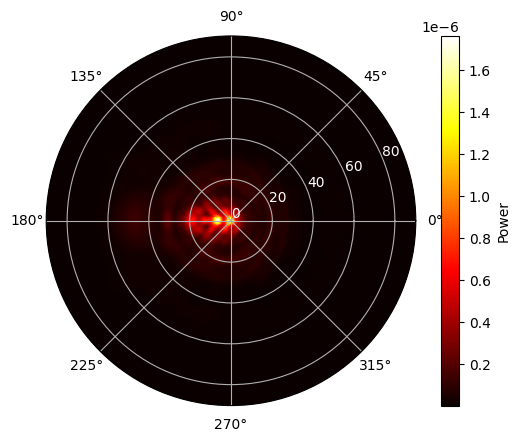

In [14]:
# sum over all simulations
I = 0
for dipole_x in dipole_x_list:
    for pol in pol_list:
        I += batch_results[f"x={dipole_x}, pol={pol}"]["far_field"].power.squeeze(drop=True)

# plot the radiation pattern in polar coordinates
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
plt.grid(False)
c = ax.pcolor(phi_array, np.rad2deg(theta_array), I, shading="auto", cmap="hot")

cb = fig.colorbar(c, ax=ax)
cb.set_label("Power")
_ = plt.setp(ax.get_yticklabels(), color="white")
plt.grid(True)

plt.show()

Now, we calculate the light extraction efficiency (LEE) within a ±15° cone, defined as the ratio of the power emitted within this cone to the total power emitted into the upper hemisphere.

In [15]:
S = I * 1e12 * np.sin(I.coords["theta"])

P = S.sel(theta=slice(0, np.deg2rad(15))).integrate(coord=["theta", "phi"])
P0 = S.sel(theta=slice(0, np.deg2rad(90))).integrate(coord=["theta", "phi"])

efficiency = P / P0

print(f"Light extraction efficiency is {1e2 * efficiency:.2f}%")

Light extraction efficiency is 34.13%


Finally, we calculate the rotationally symmetric radiation pattern by averaging the total power over the φ (azimuthal) dimension. As we can see, the results are similar to those reported in Figure 4 of the reference paper.

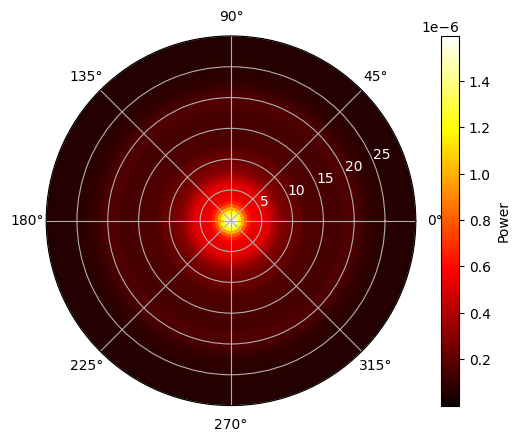

In [16]:
I_avg = I.mean(dim="phi").expand_dims(phi=phi_array)

fig = plt.figure()

ax = fig.add_subplot(111, polar=True)
plt.grid(False)
c = ax.pcolor(
    phi_array, np.rad2deg(theta_array), I_avg.transpose("theta", "phi"), shading="auto", cmap="hot"
)
cb = fig.colorbar(c, ax=ax)
cb.set_label("Power")
ax.set_ylim(0, 30)
_ = plt.setp(ax.get_yticklabels(), color="white")
plt.grid(True)

plt.show()